# Climate variable spirals

In [1]:
import glob
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

In [2]:
lfiles = glob.glob('./data/*.netcdf')
lfiles.sort()
lfiles

['./data/dataset_1950-1959_hourly_reanalysis-era5-land.netcdf',
 './data/dataset_1960-1969_hourly_reanalysis-era5-land.netcdf',
 './data/dataset_1970-1979_hourly_reanalysis-era5-land.netcdf',
 './data/dataset_1980-1989_hourly_reanalysis-era5-land.netcdf',
 './data/dataset_1990-1999_hourly_reanalysis-era5-land.netcdf',
 './data/dataset_2000-2009_hourly_reanalysis-era5-land.netcdf',
 './data/dataset_2010-2020_hourly_reanalysis-era5-land.netcdf',
 './data/dataset_2021_hourly_reanalysis-era5-land.netcdf']

In [3]:
dset = xr.open_mfdataset(lfiles)

In [4]:
dset

<xarray.Dataset>
Dimensions:    (longitude: 6, latitude: 6, time: 631151)
Coordinates:
  * longitude  (longitude) float32 72.5 72.6 72.7 72.8 72.9 73.0
  * latitude   (latitude) float32 19.25 19.15 19.05 18.95 18.85 18.75
  * time       (time) datetime64[ns] 1950-01-01T01:00:00 ... 2021-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(87647, 6, 6), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-27 02:49:28 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [5]:
dset_dmean = dset.resample(time='M').mean()

In [6]:
dset_dmean

<xarray.Dataset>
Dimensions:    (time: 864, longitude: 6, latitude: 6)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-31 1950-02-28 ... 2021-12-31
  * longitude  (longitude) float32 72.5 72.6 72.7 72.8 72.9 73.0
  * latitude   (latitude) float32 19.25 19.15 19.05 18.95 18.85 18.75
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1, 6, 6), meta=np.ndarray>

In [7]:
dset_mean = dset_dmean.mean(("longitude", "latitude"))
dset_mean

<xarray.Dataset>
Dimensions:  (time: 864)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-31 1950-02-28 ... 2021-12-31
Data variables:
    t2m      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

## Compute climatology
- The normal is typically computed by calculating a climatology over a period of at least 30 years (the climate normal period). 
- The current climate normal period is January 1981 to December 2010.

In [8]:
climatology = dset_mean.sel(time=slice('1981-01-01', '2010-12-31')).groupby("time.month").mean("time")

In [9]:
climatology

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    t2m      (month) float32 dask.array<chunksize=(1,), meta=np.ndarray>

In [10]:
anomalies = dset_mean.groupby("time.month") - climatology

In [11]:
anomalies

<xarray.Dataset>
Dimensions:  (time: 864)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-31 1950-02-28 ... 2021-12-31
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    t2m      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

In [12]:
df_mean = anomalies.to_dataframe()

In [13]:
df_mean.head()

,month,t2m
time,,
1950-01-31,1,0.317169
1950-02-28,2,-1.834595
1950-03-31,3,-1.313446
1950-04-30,4,-0.440399
1950-05-31,5,-1.008392


In [14]:
df_mean['year'] = df_mean.index.year
df_mean.head()

,month,t2m,year
time,,,
1950-01-31,1,0.317169,1950
1950-02-28,2,-1.834595,1950
1950-03-31,3,-1.313446,1950
1950-04-30,4,-0.440399,1950
1950-05-31,5,-1.008392,1950


<AxesSubplot:title={'center':'Temperature anomalies over Mumbai (reference period: 1980-2010) '}, xlabel='time'>

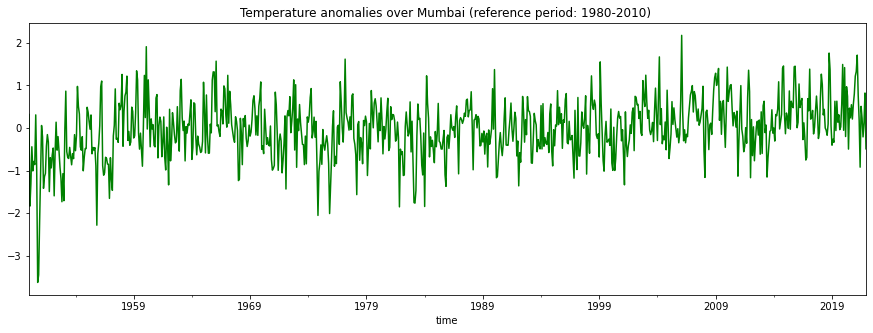

In [15]:
fig = plt.figure(1, figsize=[15,5])
df_mean['t2m'].plot(c='green', title='Temperature anomalies over Mumbai (reference period: 1980-2010) ')

In [16]:
df_mean = df_mean.set_index(['year', 'month'])

In [17]:
df_mean.tail()

t2m
year month          
2021 8      0.233337
     9     -0.208923
     10     0.124023
     11     0.822906
     12    -0.489258

## Plot spirals with polar projection

In [18]:
df_mean.index.get_level_values('year')

Int64Index([1950, 1950, 1950, 1950, 1950, 1950, 1950, 1950, 1950, 1950,
            ...
            2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021],
           dtype='int64', name='year', length=864)

In [19]:
min = df_mean['t2m'].min()
min

-3.62835693359375

Let’s shift all temperature values, so they’ll be positive but there’s still some space reserved around the origin for displaying text:

In [20]:
shift_value = abs(np.floor(min))
shift_value

4.0

In [21]:
max = df_mean['t2m'].max()
max

2.177032470703125

In [22]:
ylim = max*3

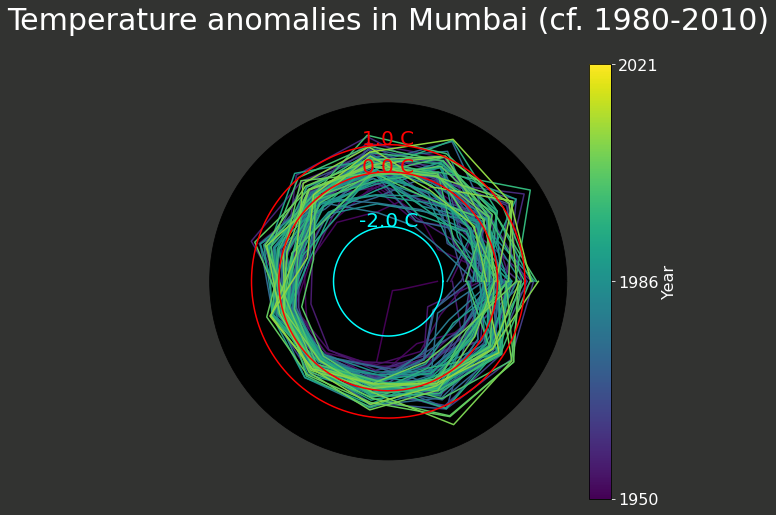

In [27]:
hc_1950 = df_mean[df_mean.index.get_level_values('year') == 1950]
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("#323331")
ax1 = fig.add_subplot(111, projection='polar')
ax1.set_facecolor('#000100')
ax1.set_ylim(0, ylim)
ax1.set_title("Temperature anomalies in Mumbai (cf. 1980-2010)\n\n", color='white', fontdict={'fontsize': 30})
ax1.axes.get_yaxis().set_ticklabels([])
ax1.axes.get_xaxis().set_ticklabels([])
ax1.grid(alpha=0) 

theta = np.linspace(0, 2*np.pi, 12)

years = df_mean.index.get_level_values('year').unique()

for index, year in enumerate(years):
    r = df_mean[df_mean.index.get_level_values('year') == year]['t2m'] + shift_value
    ax1.plot(theta, r, c=plt.cm.viridis(index*3))
    
cbar = fig.colorbar(plt.cm.ScalarMappable())
cbar.ax.tick_params(labelsize=16, color="white")
cbar.ax.set_ylabel('Year', fontsize=16, color="white")
cbar.ax.set_yticks([0., 0.5, 1.])
cbar.ax.set_yticklabels([1950, 1986, 2021], color="white")
    
full_circle_thetas = np.linspace(0, 2*np.pi, 1000)
# Value of temperature anomalies for the 3 circles
T1 = -2.0
T2 = 0.0
T3 = 1.0
blue_line_one_radii = [T1 + shift_value ]*1000
red_line_one_radii = [T2 + shift_value ]*1000
red_line_two_radii = [T3 + shift_value ]*1000

ax1.plot(full_circle_thetas, blue_line_one_radii, c='cyan')
ax1.plot(full_circle_thetas, red_line_one_radii, c='red')
ax1.plot(full_circle_thetas, red_line_two_radii, c='red')
ax1.text(np.pi/2, T1 + shift_value, str(T1) + " C", color="cyan", ha='center', fontdict={'fontsize': 20})
ax1.text(np.pi/2, T2 + shift_value, str(T2) + " C", color="red", ha='center', fontdict={'fontsize': 20})
ax1.text(np.pi/2, T3 + shift_value, str(T3) + " C", color="red", ha='center', fontdict={'fontsize': 20})
fig.savefig("spiral_all_1950-2021.png")

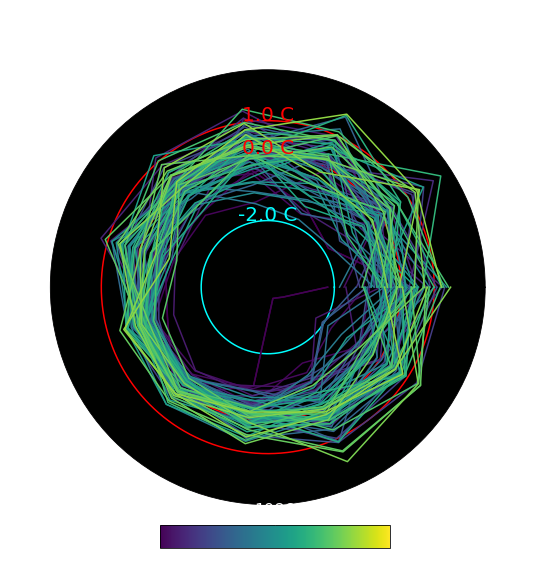

In [46]:
# To be able to write out the animation as a GIF file
import sys
from matplotlib.animation import FuncAnimation
# Create the base plot
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot(111, projection='polar')
ax1.set_facecolor('#000100')
ax1.set_ylim(0, ylim)
ax1.set_title("Temperature anomalies in Mumbai\n (cf. 1980-2010)", color='white', fontdict={'fontsize': 25})
ax1.axes.get_yaxis().set_ticklabels([])
ax1.axes.get_xaxis().set_ticklabels([])
ax1.grid(alpha=0) 

full_circle_thetas = np.linspace(0, 2*np.pi, 1000)
# Value of temperature anomalies for the 3 circles
T1 = -2.0
T2 = 0.0
T3 = 1.0
blue_line_one_radii = [T1 + shift_value ]*1000
red_line_one_radii = [T2 + shift_value ]*1000
red_line_two_radii = [T3 + shift_value ]*1000

ax1.plot(full_circle_thetas, blue_line_one_radii, c='cyan')
ax1.plot(full_circle_thetas, red_line_one_radii, c='red')
ax1.plot(full_circle_thetas, red_line_two_radii, c='red')
ax1.text(np.pi/2, T1 + shift_value, str(T1) + " C", color="cyan", ha='center', fontdict={'fontsize': 20})
ax1.text(np.pi/2, T2 + shift_value, str(T2) + " C", color="red", ha='center', fontdict={'fontsize': 20})
ax1.text(np.pi/2, T3 + shift_value, str(T3) + " C", color="red", ha='center', fontdict={'fontsize': 20})

cb_ax = fig.add_axes([0.325, 0.05, 0.4, 0.04])
cbar = fig.colorbar(plt.cm.ScalarMappable(), cax=cb_ax, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16, color="white")
cbar.ax.set_xlabel('Year', fontsize=16, color="white")
cbar.ax.set_xticks([0., 0.5, 1.])
cbar.ax.set_xticklabels([1950, 1986, 2021], color="white")
cbar.ax.xaxis.set_ticks_position('top')

theta = np.linspace(0, 2*np.pi, 12)

years = df_mean.index.get_level_values('year').unique()

def update(i):
    # Specify how we want the plot to change in each frame.
    # We need to unravel the for loop we had earlier.
    year = years[i]
    r = df_mean[df_mean.index.get_level_values('year') == year]['t2m'] + shift_value
    ax1.plot(theta, r, c=plt.cm.viridis(i*3)) 
    return ax1

anim = FuncAnimation(fig, update, frames=len(years), interval=50, blit=False)
anim.save('climate_spiral.gif', dpi=120, writer='pillow', savefig_kwargs={'facecolor': '#323331'})